In [1]:
# UT-TOR-DATA-PT-01-2020-U-C Week 10 Assignment
# SQLAlchemy Challenge
# Step 1: Climate Analysis and Exploration
# Bonus: Temperature Analysis I & II, Daily Rainfall Average
# (c) Boris Smirnov

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd
from scipy import stats

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc, extract

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
AutomapBase = automap_base()

# reflect the tables
AutomapBase.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
AutomapBase.classes.items()

[('measurement', sqlalchemy.ext.automap.measurement),
 ('station', sqlalchemy.ext.automap.station)]

In [9]:
# Save references to each table
Station = AutomapBase.classes.station
list(inspect(Station).columns)

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

In [10]:
Measurement = AutomapBase.classes.measurement
list(inspect(Measurement).columns)

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis


## Precipitation analysis


Design a query to retrieve the last 12 months of precipitation data and plot the results

In [12]:
# Calculate the date 1 year before the last data point in the database
first_date = session.query(func.min(Measurement.date)).scalar()
last_date = session.query(func.max(Measurement.date)).scalar()
year_before = (dt.date(*[int(d) for d in last_date.split('-')]) - dt.timedelta(days=365)).isoformat()
(first_date, last_date, year_before)

('2010-01-01', '2017-08-23', '2016-08-23')

In [13]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_before).\
    order_by(Measurement.date) # Sort the dataframe by date
print(f"Total number of records returned for 1 last year of observations: {query.count()}")

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(query)
precip_data_df.set_index('date', inplace=True)
precip_data_df.dropna(inplace=True)
print(f"Total number or precipitation records for 1 last year of observations: {len(precip_data_df)}")
precip_data_df.head(6)

Total number of records returned for 1 last year of observations: 2223
Total number or precipitation records for 1 last year of observations: 2015


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45


In [14]:
# There are several observations from different stations for each day
# Since it's a vacation we're talking about, I'll consider "worst case scenario"
# and use max daily precipitation volumes for plotting the chart
max_precip_df = precip_data_df.groupby(level=0).max()
max_precip_df.columns = ['Precipitation (in)']
print(f"Number of observed days: {len(max_precip_df)}")
max_precip_df.head(1)

Number of observed days: 365


,Precipitation (in)
date,
2016-08-24,2.28


<Figure size 432x288 with 0 Axes>

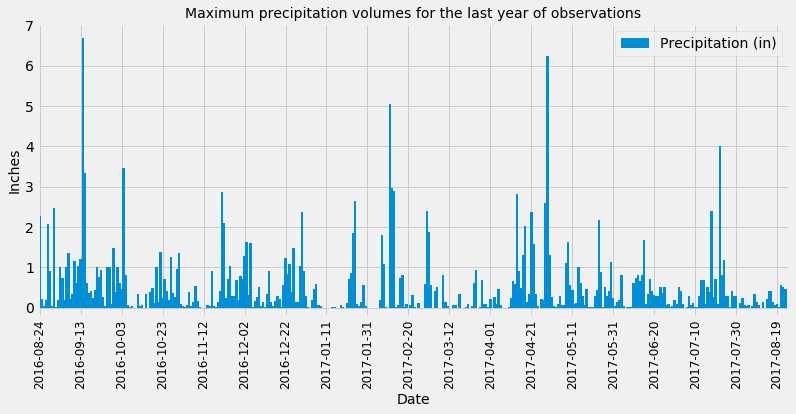

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
fig = plt.figure()

axes = max_precip_df.plot(kind='bar', figsize=(12, 5), width=1.2)

axes.set_title(
    'Maximum precipitation volumes for the last year of observations',
    fontdict={'fontsize': 14}
)

axes.set_xlabel('Date', fontdict={'fontsize': 14})
xticks = range(0, 365, 20)
axes.set_xticks(xticks)
axes.set_xticklabels([max_precip_df.index[i] for i in xticks], fontdict={'fontsize': 12})
axes.set_xlim(left=-1, right=366)

axes.set_ylabel('Inches', fontdict={'fontsize': 14})
axes.set_ylim(bottom=-0.2)

fig.tight_layout()
plt.savefig('Images/1_max_precip.png', bbox_inches = 'tight')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [17]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station).count()
print(f"Total number of stations in the dataset: {total_stations}")

Total number of stations in the dataset: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_q = session.query(
    Measurement.station, Station.name, func.count(Measurement.station).label('measure counts')).\
    join(Station, Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(desc('measure counts'))

pd.DataFrame(stations_q)

,station,name,measure counts
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station_id = stations_q[0][0]

tobs_q = session.query(
        func.min(Measurement.tobs).label('Lowest Temperature'),
        func.max(Measurement.tobs).label('Highest Temperature'),
        func.round(func.avg(Measurement.tobs), 1).label('Average Temperature')
    ).filter_by(station=most_active_station_id)

pd.DataFrame(tobs_q)

,Lowest Temperature,Highest Temperature,Average Temperature
0,54.0,85.0,71.7


The station with the highest number of temperature observations: USC00519281


<Figure size 432x288 with 0 Axes>

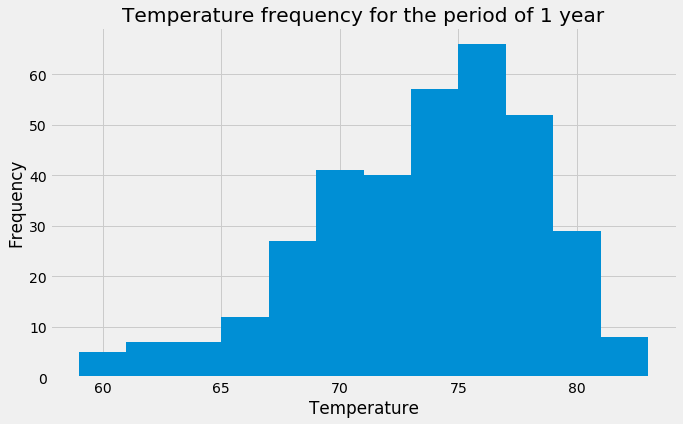

In [20]:
# Choose the station with the highest number of temperature observations.
tobs_best_station_id = session.query(Measurement.station, func.count(Measurement.tobs).label('tobs_count')).\
    group_by(Measurement.station).\
    order_by(desc('tobs_count')).\
    first()[0]

print(f"The station with the highest number of temperature observations: {tobs_best_station_id}")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_q = session.query(Measurement.date, Measurement.tobs).\
    filter_by(station=tobs_best_station_id).\
    filter(Measurement.date > year_before)

tobs_df = pd.DataFrame(tobs_q)

fig = plt.figure()
axes = tobs_df.plot(
    kind='hist', bins=12, figsize=(10,6), legend=False,
    title='Temperature frequency for the period of 1 year',
)

axes.set_xlabel('Temperature')
fig.tight_layout()
plt.savefig('Images/2_temp_freq.png', bbox_inches = 'tight')
plt.show()

# Bonus Challenge Assignment


## Temperature Analysis I


Identify the average temperature in June at all stations across all available years in the dataset.


Do the same for December temperature.


### Prepare data for paired t-test


The goal is to build a dataset of pairs of measurements: for every year for every station get average temperature in June AND in December.


In the end we get 2 series of paired mesurements, each made by the same station in different months.


In [21]:
# Here we make the database calculate averages for us and group the data
avg_query = session.query(
                extract('year', Measurement.date).label('year'),
                Measurement.station,
                extract('month', Measurement.date).label('month'),
                func.avg(Measurement.tobs).label('avg_temp')).\
            filter(extract('month', Measurement.date).in_([6, 12])).\
            group_by('year', Measurement.station, 'month')

# The group_by columns become the index in the DataFrame
averages_df = pd.DataFrame(avg_query).set_index(['year', 'station', 'month'])
averages_df

avg_temp
year station     month           
2010 USC00511918 6      75.620690
                 12     70.000000
     USC00513117 6      74.800000
                 12     70.967742
     USC00514830 6      73.689655
...                           ...
2017 USC00516128 6      74.928571
     USC00517948 6      78.600000
     USC00519281 6      74.766667
     USC00519397 6      79.200000
     USC00519523 6      78.896552

[122 rows x 1 columns]

In [22]:
# Here we reshape the dataset, making separate columns for each month...
avg_months_df = averages_df.unstack()
avg_months_df.head()

avg_temp           
month                    6          12
year station                          
2010 USC00511918  75.620690  70.000000
     USC00513117  74.800000  70.967742
     USC00514830  73.689655  69.233333
     USC00516128  72.863636  69.483871
     USC00517948  76.750000  69.500000

In [23]:
# ... and get rid of incomplete data - where we do not have paired measurements (for both months)
avg_months_df.dropna(inplace=True)
avg_months_df.describe()

avg_temp           
month         6          12
count  56.000000  56.000000
mean   74.799878  71.201302
std     2.144602   2.001284
min    70.733333  66.709677
25%    72.940909  70.048387
50%    74.941667  70.648352
75%    76.538462  73.091667
max    78.692308  76.791667

In [24]:
# Two parallel series of measurements
june_s = avg_months_df.iloc[:, 0]
december_s = avg_months_df.iloc[:, 1]

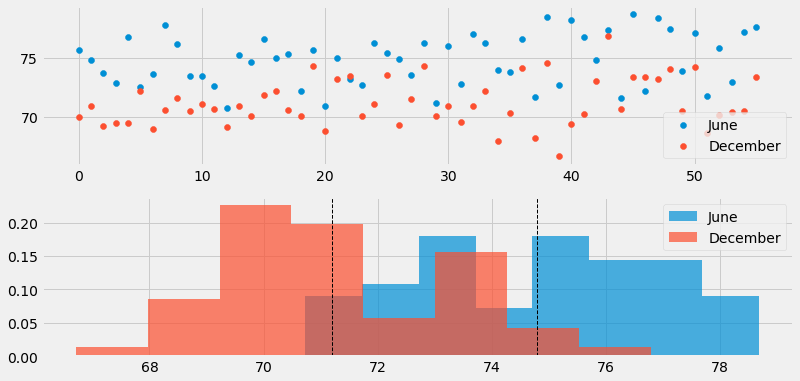

In [25]:
# Sorry, this isn't my code, I copy-pasted it from lecture materials (thanks, Daniel de R.)
# UT-TOR-DATA-PT-01-2020-U-C/07-Project-1/3/Activities/02-Ins_TTest/Solved/Ins_independent_ttest.ipynb
plt.figure(figsize=(12,6))

# Scatter Plot of Data
plt.subplot(2, 1, 1)
plt.scatter(range(len(june_s)), june_s, label="June")
plt.scatter(range(len(december_s)), december_s, label="December")
plt.legend()

# Histogram Plot of Data
plt.subplot(2, 1, 2)
plt.hist(june_s, 8, density=True, alpha=0.7, label="June")
plt.hist(december_s, 8, density=True, alpha=0.7, label="December")
plt.axvline(june_s.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(december_s.mean(), color='k', linestyle='dashed', linewidth=1)
plt.legend()  

plt.savefig('Images/3_ttest.png', bbox_inches = 'tight')
plt.show()

In [26]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant.
stats.ttest_rel(june_s, december_s)

Ttest_relResult(statistic=13.27434875934499, pvalue=8.635821572107224e-19)

### Conclusions and Q/A


1. The result of t-test yielded p-value = $8.64*10^{-19}$ that shows statistically significant difference between average temperatures in June and December, even on Hawaii.


2. Q: Will you use a paired t-test, or an unpaired t-test? Why?


* A: For this particular test I specifically prepared data samples to be suitable for [dependent t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples). The null-hypothesis for the test was that average temperatures in June and December on Hawaii were similar. To test it we had a number of stations at different parts of Hawaiis. To make the test meaningful and independent of the differences in station locations, the comparison of measurements were done only for a single station - no measurements from two different stations were compared to one another. This approach constitutes paired difference test, where each pair of samples is obtained from a single subject.

## Temperature Analysis II

In [27]:
# Slightly modified: added rounding average, and made it return tuple, not a list of 1 tuple
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(
            func.min(Measurement.tobs),
            func.round(func.avg(Measurement.tobs), 1),
            func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()[0]

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.6, 74.0)


In [28]:
# This function called `past_period` will accept start date and end date in the format '%Y-%m-%d' 
# and return start date and end date for the same days of past year that has climate data in hawaii database
# Leap years are not accounted for, so the days will not be the same (1 day offset if after Feb 29, 2020)
# I guess, I should have used Panda's Time series / date functionality...
def past_period(start_date, end_date):
    global last_date # previously retrieved last date in the database

    # validation
    assert end_date > start_date
    assert end_date > last_date

    # convertion
    last_d = dt.date(*[int(d) for d in last_date.split('-')])
    start_d = dt.date(*[int(d) for d in start_date.split('-')])
    end_d = dt.date(*[int(d) for d in end_date.split('-')])
    
    # calculation
    delta = end_d - last_d
    year_shift = delta.days // 365 
    day_shift = delta.days % 365
    if day_shift > 0:
        year_shift +=1
    delta = dt.timedelta(days = 365 * year_shift)

    return (start_d - delta).isoformat(), (end_d - delta).isoformat()

# function usage example
print(past_period('2020-02-28', '2020-03-12'))

('2017-02-28', '2017-03-13')


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
future_vacation = ('2020-07-27', '2020-08-05')
past_vacation = past_period(*future_vacation)
temps_stats = calc_temps(*past_vacation)
temps_stats # (min, avg, max)

(72.0, 79.3, 84.0)

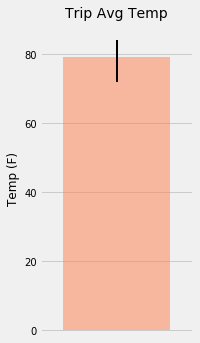

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(3, 5))
axes=  plt.subplot()
axes.bar([0.5], height=temps_stats[1], width=0.7, color='coral', alpha=0.5)
axes.errorbar(
    [0.5], temps_stats[1],
    yerr=[[temps_stats[1]-temps_stats[0]], [temps_stats[2]-temps_stats[1]]],
    ecolor='black', elinewidth=2)

axes.set_title('Trip Avg Temp', fontdict={'fontsize': 14})

axes.set_xlim(left=0.0, right=1.0)
axes.set_xticklabels([])

axes.set_yticks(range(0, 81, 20))
axes.set_ylabel('Temp (F)', fontdict={'fontsize': 12})
axes.set_ylim(bottom=-1, top=89)
plt.setp(axes.get_yticklabels(), fontsize=10)

axes.grid(axis='x')

fig.tight_layout()
plt.savefig('Images/4_trip_avg_temp.png', bbox_inches = 'tight')
plt.show()

## Daily Rainfall Average

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_q = session.query(
        Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
        func.sum(Measurement.prcp).label('total_prcp')).\
    join(Station, Measurement.station == Station.station).\
    filter(Measurement.date >= past_vacation[0]).\
    filter(Measurement.date <= past_vacation[1]).\
    group_by(Measurement.station).\
    order_by(desc('total_prcp'))

pd.DataFrame(prcp_q)

,station,name,latitude,longitude,elevation,total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.31
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.38
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.38
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.19
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.01
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# was set above
#future_vacation = ('2020-07-27', '2020-08-05')

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start=future_vacation[0], end=future_vacation[1], name='date')

# Stip off the year and save a list of %m-%d strings
md_list = trip_dates.strftime('%m-%d').tolist()

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for md in md_list:
   normals.extend(daily_normals(md))


In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, index=trip_dates, columns=['tmin', 'tavg', 'tmax'])
normals_df

,tmin,tavg,tmax
date,,,
2020-07-27,68.0,76.581818,83.0
2020-07-28,69.0,76.464286,82.0
2020-07-29,69.0,76.470588,83.0
2020-07-30,69.0,77.351852,84.0
2020-07-31,72.0,77.035714,83.0
2020-08-01,67.0,75.540000,83.0
2020-08-02,68.0,75.603774,84.0
2020-08-03,70.0,76.611111,85.0
2020-08-04,69.0,76.711538,84.0


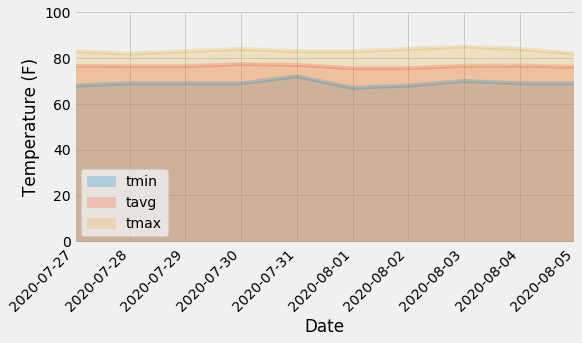

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
axes = normals_df.plot(kind='area', stacked=False, figsize=(8, 4), alpha=0.25)

# X axis
axes.set_xlabel('Date')
axes.set_xticks(trip_dates)
days_loc = mdates.DayLocator()
axes.xaxis.set_major_locator(days_loc)
axes.set_xticklabels(
    labels=trip_dates.strftime('%Y-%m-%d').tolist(), rotation='45', fontdict={'horizontalalignment': 'right'})

# Y axix
axes.set_ylabel('Temperature (F)')
axes.set_ylim(bottom=-1, top=101)

plt.savefig('Images/5_normals.png', bbox_inches = 'tight')
plt.show()